# C1 - Introduction to Human and Computer Vision
## Week 3

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import matplotlib.pyplot as plt

# Get project's root directory
BASE_PATH = os.path.join(re.search(r'.+(Team5)', os.getcwd())[0], 'week3')
os.chdir(BASE_PATH)
BASE_PATH

'/Users/arnaubarrera/Desktop/MSc Computer Vision/C1. Intro to Human and CV/Team5/week3'

### Load datasets

In [3]:
from src.image_dataset import ImageDataset, ColorSpace
from src.consts import DescriptorType

DATA_DIRECTORY = '../data'

params = {
    'colorspace': ColorSpace.CieLab,
    'intervals': [7, 7, 7],
    'rows': 12,
    'columns': 12,
    'channels': [[0], [1], [2]]
}

BDDataset = ImageDataset(f'{DATA_DIRECTORY}/BBDD', DescriptorType.Block, params)

### Task 1 - Filter noise

In [4]:
QSD1_W3 = ImageDataset(f'{DATA_DIRECTORY}/qsd1_w3', DescriptorType.Block, params)

In [6]:
import cv2
import importlib
import matplotlib.pyplot as plt

import src.noise_removal
importlib.reload(src.noise_removal)
from src.noise_removal import PSNR, SSIM

Image 5 PSNR: 31.255 dB & SSIM: 0.596
Image 6 PSNR: 29.669 dB & SSIM: 0.551
Image 16 PSNR: 31.325 dB & SSIM: 0.465
Image 18 PSNR: 31.602 dB & SSIM: 0.385
Image 20 PSNR: 31.127 dB & SSIM: 0.529
Image 23 PSNR: 31.257 dB & SSIM: 0.367
Image 29 PSNR: 31.565 dB & SSIM: 0.474


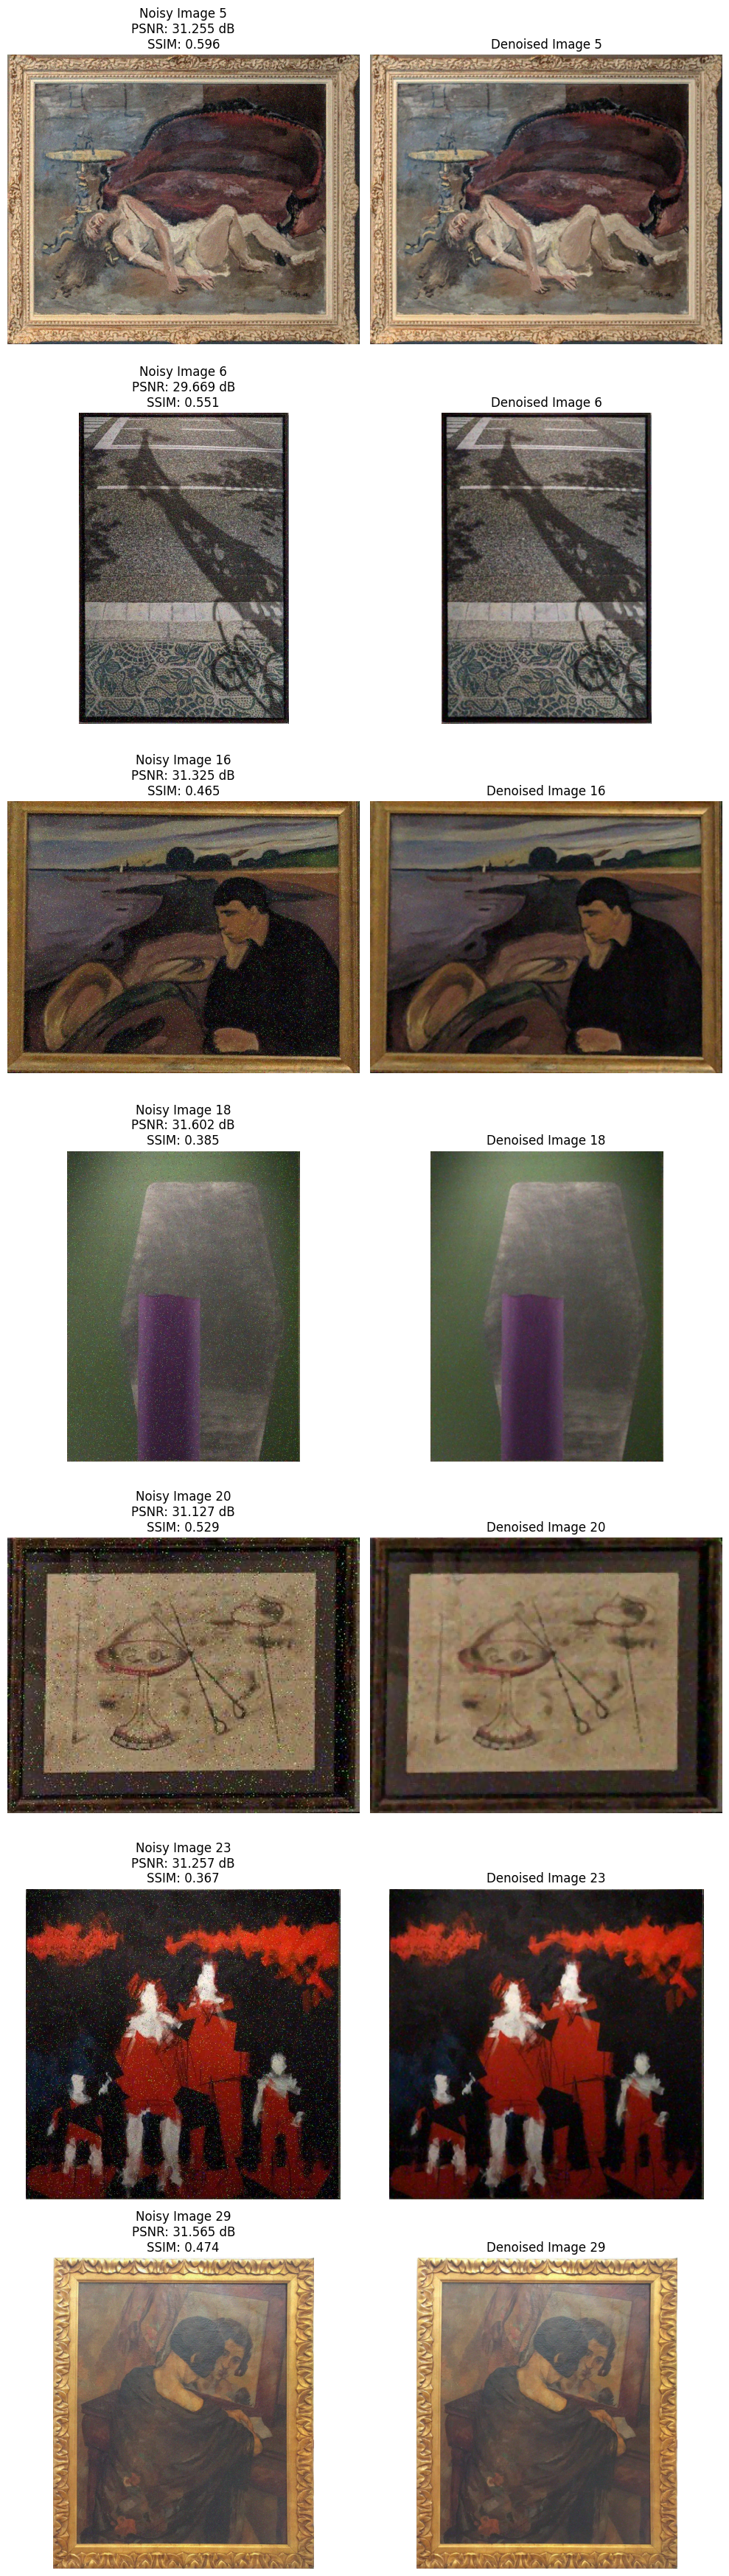

In [22]:
# List of noisy image indices in qsd1_w3 dataset
qsd1_w3_noisy_images = [5, 6, 16, 18, 20, 23, 29]
qsd1_w3_not_noisy_images = [1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 21, 22, 24, 25, 26, 27, 28]

num_images = len(qsd1_w3_noisy_images)
fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5)) 

for idx, noise_image_index in enumerate(qsd1_w3_noisy_images):

    noisy_image = cv2.imread(QSD1_W3.images[noise_image_index].path)
    denoised = cv2.medianBlur(noisy_image, 3) # 3x3 kernel size

    # Compute PSNR
    psnr_value = PSNR(noisy_image, denoised)
    ssim_value = SSIM(noisy_image, denoised)
    print(f"Image {noise_image_index} 
          PSNR: {psnr_value:.3f} dB & 
          SSIM: {ssim_value:.3f}")

    # Noisy image
    axes[idx, 0].imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
    axes[idx, 0].set_title(f"Noisy Image {noise_image_index}\nPSNR: {psnr_value:.3f} dB\nSSIM: {ssim_value:.3f}")
    axes[idx, 0].axis('off')

    # Denoised image
    axes[idx, 1].imshow(cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB))
    axes[idx, 1].set_title(f"Denoised Image {noise_image_index}")
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

- Median Blur looks to work pretty good for the dataset noisy images (most of them look to have salt-and-pepper)

- Also, a 3x3 kernel size works better than a 5x5, as the 5x5 smoothes way too much the image.

- We are also able to see that, for the qsd1_w3 dataset, the highest PSNR of an image WITH NOISE is 31.602 & SSIM  0.596, therefore we can set a threshold around this value.

### Task 2 - Texture descriptors

In [29]:
import src.descriptors.image_texture_descriptor
import importlib
importlib.reload(src.descriptors.image_texture_descriptor)
from src.image_dataset import ImageDataset, ColorSpace
from src.image import Image
from src.consts import DescriptorType
import os
import re
import matplotlib.pyplot as plt
import cv2
import numpy as np
import scipy


In [3]:
DATA_DIRECTORY = '../data'

# Get project's root directory
BASE_PATH = os.path.join(re.search(r'.+(Team5)', os.getcwd())[0], 'week3')
os.chdir(BASE_PATH)
BASE_PATH

'/Users/arnaubarrera/Desktop/MSc Computer Vision/C1. Intro to Human and CV/Team5/week3'

In [4]:
params = {
    'colorspace': ColorSpace.CieLab,
    'intervals': 7,
    'rows': 2,
    'columns': 2,
    'channels': [[0], [1], [2]],
}

#QSD1_W3 = ImageDataset(f'{DATA_DIRECTORY}/qsd1_w3', DescriptorType.Texture, params)

channel = 2


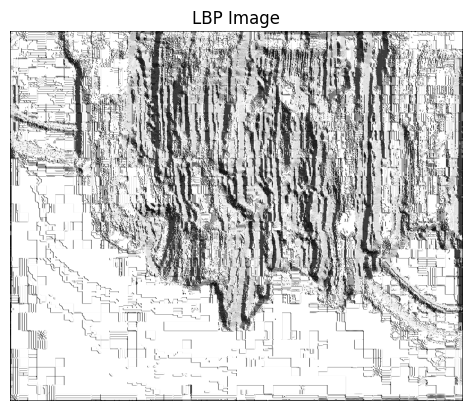

In [8]:
img1 = Image(f'{DATA_DIRECTORY}/qsd1_w3/00000.jpg', DescriptorType.Texture, params)

lbp_descriptor = img1.descriptors.values[:,:,channel]

plt.imshow(lbp_descriptor, cmap='gray')
plt.axis('off')
plt.title("LBP Image")
plt.show()

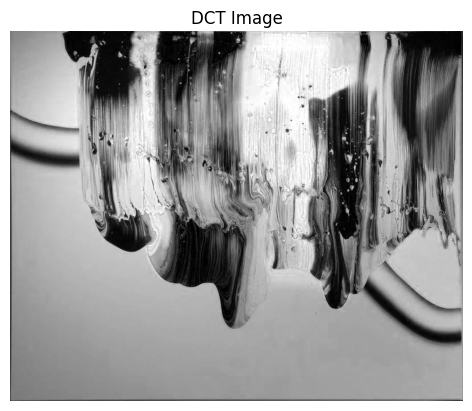

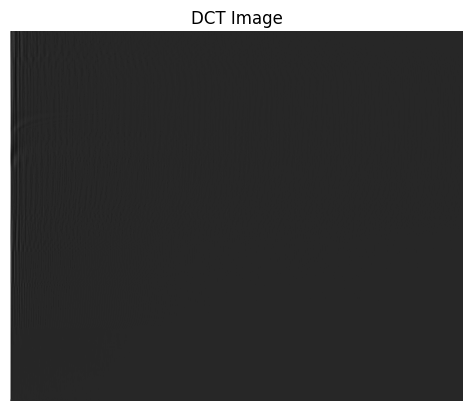

In [36]:
image = cv2.imread(f'{DATA_DIRECTORY}/qsd1_w3/00000.jpg')
image_channel = image[:, :, channel]

plt.imshow(image_channel, cmap='gray')
plt.axis('off')
plt.title("DCT Image")
plt.show()

dct_channel = scipy.fftpack.dct(image_channel)         # the dct
inverse_dct = scipy.fftpack.idct(dct_channel)

plt.imshow(inverse_dct, cmap='gray')
plt.axis('off')
plt.title("DCT Image")
plt.show()

### Task 3 - Background removal (max 2 paintings per image)

### Task 4 - Retrieval system

In [74]:
import pickle

# Get ground truth
with open(f'{DATA_DIRECTORY}/qsd1_w1/gt_corresps.pkl', 'rb') as f:
    ground_truth = pickle.load(f)

In [75]:
from src.evaluation import compute_results_by_similarity, compute_results_by_distance
from src.metrics import SimilarityType, DistanceType
import numpy as np

metric = DistanceType.l1

res = compute_results_by_distance(
    BDDataset, QueryDataset, ground_truth, metric,
)

result = {}
result[metric.__name__] = {
    'mapk1': np.mean(res['apk1']),
    'mapk5': np.mean(res['apk5'])
}

print(result)

{'l1_distance': {'mapk1': np.float64(0.9), 'mapk5': np.float64(0.9166666666666666)}}


### Task 5 - .pkl results generation

In [76]:
TestDataset = ImageDataset(f'{DATA_DIRECTORY}/qst_w2/w2/qst1_w2/', DescriptorType.Block, params)

In [78]:
result = []
for image in TestDataset:
    distnaces_list = []
    for image2 in BDDataset:
        distnaces = image.compute_distance(image2, type=DistanceType.l1)
        distance = np.mean(distnaces)
        distnaces_list.append(distance)
    top_k = np.argsort(distnaces_list)[:10]

    result.append([BDDataset[i].index for i in top_k])

In [79]:
result

[[35, 194, 212, 205, 252, 40, 270, 226, 97, 16],
 [131, 110, 121, 240, 128, 173, 213, 231, 46, 180],
 [91, 51, 225, 117, 187, 58, 146, 215, 184, 85],
 [182, 85, 97, 184, 226, 212, 165, 35, 224, 187],
 [222, 194, 120, 205, 35, 252, 187, 40, 226, 211],
 [260, 286, 248, 21, 26, 279, 84, 123, 133, 57],
 [117, 217, 5, 73, 146, 106, 21, 68, 213, 162],
 [78, 147, 248, 227, 155, 84, 99, 140, 65, 253],
 [257, 21, 138, 57, 197, 106, 258, 46, 279, 217],
 [218, 110, 240, 231, 216, 173, 128, 157, 133, 180],
 [67, 182, 184, 85, 97, 38, 114, 224, 35, 165],
 [132, 130, 192, 225, 88, 103, 113, 58, 215, 51],
 [25, 104, 200, 29, 145, 154, 163, 42, 143, 105],
 [212, 270, 85, 194, 97, 148, 165, 5, 187, 1],
 [34, 173, 216, 197, 162, 240, 238, 128, 254, 21],
 [176, 29, 200, 12, 105, 16, 60, 24, 95, 205],
 [150, 95, 93, 176, 16, 205, 12, 200, 271, 187],
 [85, 254, 187, 92, 226, 79, 224, 165, 110, 157],
 [22, 205, 16, 12, 93, 211, 14, 1, 194, 252],
 [36, 106, 258, 49, 217, 162, 18, 5, 35, 209],
 [248, 205, 244

In [80]:
with open(f'./data_results/result.pkl', 'wb') as file:
    # Use pickle.dump to write the list to the file
    pickle.dump(result, file)

In [81]:
TestDataset = ImageDataset(f'{DATA_DIRECTORY}/qst_w2/w2/qst2_w2/qst2_w1', DescriptorType.Block, params)

In [82]:
for image in TestDataset:
    _, mask = get_mask_and_foreground(image.descriptors.original_image)
    image.descriptors.compute_image_histogram_descriptor(
        params['intervals'],
        params['rows'],
        params['columns'],
        params['channels'],
        mask=mask)

In [85]:
result = []
for image in TestDataset:
    distnaces_list = []
    for image2 in BDDataset:
        distnaces = image.compute_distance(image2, type=DistanceType.l1)
        distance = np.mean(distnaces)
        distnaces_list.append(distance)
    top_k = np.argsort(distnaces_list)[:10]

    result.append([BDDataset[i].index for i in top_k])

In [86]:
result

[[35, 197, 217, 146, 208, 21, 68, 106, 258, 11],
 [276, 176, 22, 281, 12, 261, 74, 152, 92, 95],
 [85, 224, 187, 97, 165, 146, 184, 182, 226, 79],
 [35, 68, 197, 226, 217, 5, 21, 79, 41, 273],
 [212, 35, 187, 226, 40, 68, 18, 41, 165, 217],
 [286, 57, 271, 21, 116, 72, 225, 241, 126, 103],
 [85, 187, 79, 224, 184, 226, 41, 146, 217, 165],
 [217, 173, 106, 127, 240, 216, 21, 190, 73, 46],
 [176, 105, 29, 200, 95, 12, 150, 93, 60, 205],
 [110, 57, 225, 271, 218, 187, 146, 46, 241, 259],
 [179, 219, 240, 254, 127, 173, 216, 128, 238, 231],
 [225, 130, 31, 160, 72, 110, 163, 215, 113, 127],
 [93, 187, 95, 12, 191, 137, 195, 149, 150, 42],
 [231, 110, 240, 216, 123, 21, 121, 57, 46, 128],
 [183, 15, 118, 133, 46, 21, 139, 138, 174, 221],
 [81, 244, 218, 82, 110, 37, 150, 105, 271, 281],
 [286, 225, 170, 57, 146, 130, 187, 46, 21, 271],
 [130, 58, 225, 215, 192, 132, 160, 51, 161, 239],
 [187, 205, 203, 93, 150, 16, 46, 271, 146, 110],
 [227, 57, 133, 121, 157, 110, 218, 26, 244, 84],
 [257,

In [87]:
with open(f'./data_results/result.pkl', 'wb') as file:
    # Use pickle.dump to write the list to the file
    pickle.dump(result, file)